Se deben generar 5 robots como Roombas, que limpien una oficina y cada una tiene capacidad de 5 unidades de basura. Al inicio, se debe ingresar un .txt con las dimensiones de la sala (5<=x<=50) y después se dará el mapeo, EJ:


4 4  
S 0 X 3  
1 2 7 X  
2 X 2 2  
0 0 0 P  


6 5  
S 4 0 6 0   
6 X 0 X 4  
0 X 7 X 0  
5 0 0 X 8  
0 0 X 0 0  
0 0 0 0 P  

Los espacios en los que hay una X, son espacios inaccesibles, P es la papelera y S es el punto de partida de los robots. Los robots no pueden conocer el mapa, solo pueden conocer la ubicación de la papelera. Los robots deberán explorar y recoger las unidades de basura que puedan, en caso de requerir ayuda, pueden solicitar ayuda a los demás robots. Cabe destacar que los robots no pueden saber nada del mapa a excepción de lo que se mapea, en caso de que los robots muestren que saben donde hay basura, se penalizarán por 50 puntos.

Los robots son capaces de ver y dar a conocer a los demás robots solo los bloques con los que estén colindando. Solo puede saber a su alrededor si hay obstáculos, otro robot o basura, más no puede saber cuanta basura hay hasta que está en ese espacio.   
EJ:

? ? ? ? ? ? ? ?  
? ? ? B B B ? ?  
? ? ? B R B ? ?  
? ? ? B B X ? ?  
? ? ? ? ? ? ? ?  



Si tienes alguna duda, habla con el profesor o revisa el repo de la clase.


In [225]:
# PARA COLAB SOLAMENTE O ENTORNOS EXTERNOS
# !pip install mesa scikit-learn numpy pandas matplotlib networkx

In [226]:
# Imports
from mesa import Agent, Model
from mesa.time import RandomActivation
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import heapq
import random
%matplotlib inline
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128
import pandas as pd
from mesa.datacollection import DataCollector
from IPython.display import HTML, display
import heapq
import numpy as np
import networkx as nx

In [227]:
def leer_mapa(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
        mapaREAL = [list(line.replace(" ", "").strip()) for line in lines[1:]]

    filas = len(mapaREAL)
    columnas = len(mapaREAL[0])

    mapaUNKNOWN = [fila[:] for fila in mapaREAL]  # Crear una copia de mapaREAL

    for i in range(filas):
        for j in range(columnas):
            if mapaREAL[i][j] not in ['S', 'P']:
                mapaUNKNOWN[i][j] = '?'

    return mapaREAL, mapaUNKNOWN

def construir_grafo(mapa):
    grafo = {}
    filas = len(mapa)
    columnas = len(mapa[0])

    for i in range(filas):
        for j in range(columnas):
            if mapa[i][j] != 'X':
                nodo = (i, j)
                vecinos = []

                if i - 1 >= 0 and mapa[i-1][j] != 'X': vecinos.append((i-1, j))
                if i + 1 < filas and mapa[i+1][j] != 'X': vecinos.append((i+1, j))
                if j - 1 >= 0 and mapa[i][j-1] != 'X': vecinos.append((i, j-1))
                if j + 1 < columnas and mapa[i][j+1] != 'X': vecinos.append((i, j+1))

                grafo[nodo] = vecinos
                
    
        # Vamos a dibujar el grafo para entenderlo:

    # G = nx.DiGraph()

    # # Agrega los nodos al grafo
    # for nodo, vecinos in grafo.items():
    #     G.add_node(nodo)
    #     for vecino in vecinos:
    #         G.add_edge(nodo, vecino)
            
    # # Se espejea el dibujo para que Rodri no me esté molestando
    # pos = {nodo: (x, -y) for nodo, (x, y) in nx.spring_layout(G).items()}
    
    # # Dibuja el grafo utilizando matplotlib
    # pos = {nodo: nodo for nodo in G.nodes()}  # Definir la posición de los nodos para que se dibujen en sus coordenadas
    # nx.draw(G, pos, with_labels=True, node_size=1000, font_size=10, node_color='lightblue', font_color='black')

    # # Rotar el gráfico
    # plt.xticks(rotation=90)  # Cambia el ángulo de las etiquetas del eje x (en grados)

    # # Iguala el aspecto del gráfico para que las proporciones no se distorsionen
    # plt.gca().set_aspect('equal')

    # # Muestra el dibujo del grafo
    # plt.show()

    return grafo

In [228]:
# Se definen algoritmos

def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

# Implementación del algoritmo A*
def a_star_search(graph, start, goal):
    frontier = []
    heapq.heappush(frontier, (0, start))
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0

    while frontier:
        _, current = heapq.heappop(frontier)
        if current == goal:
            break
        for next in graph[current]:
            new_cost = cost_so_far[current] + 1
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost + heuristic(goal, next)
                heapq.heappush(frontier, (priority, next))
                came_from[next] = current

    # Reconstruct path
    current = goal
    path = []
    while current != start:
        path.append(current)
        current = came_from[current]
    path.append(start)
    path.reverse()
    return path
    

In [229]:
# Definición de Agentes

class Robot(Agent):
    def __init__(self, unique_id, model, inicio):
        super().__init__(unique_id, model)
        self.posicion = inicio
        self.capacidad = 5
        self.mapeoIniciado = False
        self.mapeoIniTerminado = False
        self.mapeoTerminado = False
        self.pasos = 0

    def mapeoInicial(self):
        mapaU = self.model.mapaUNKNOWN
        mapaR = self.model.mapaREAL
        columnas = len(mapaU[0])
        filas = len(mapaU)
        if columnas % 3 == 0:
            agentesIniciales = int(np.ceil(columnas / 3))
            desplazamiento = 3
        else:
            agentesIniciales = int(np.floor(columnas / 2))
            desplazamiento = 2

        posicionInicial = (0, 1)

        if self.unique_id in range(agentesIniciales) and not self.mapeoIniTerminado:
            
            if self.unique_id == 0:
                if mapaR[posicionInicial[0]][posicionInicial[1]] == 'X':
                    posicionInicial = (posicionInicial[0] + 1, posicionInicial[1])
                
                destino = (filas - 1, 1)
                if mapaR[destino[0]][destino[1]] == 'X':
                    destino = (destino[0] - 1, destino[1])
            
            else:
                posicionInicial = (posicionInicial[0], posicionInicial[1] + (desplazamiento * self.unique_id))
                if mapaR[posicionInicial[0]][posicionInicial[1]] == 'X':
                    posicionInicial = (posicionInicial[0] + 1, posicionInicial[1])

                destino = (filas - 1, posicionInicial[1])
                if mapaR[destino[0]][destino[1]] == 'X':
                    destino = (destino[0] - 1, destino[1])

            return posicionInicial, destino
        else:
            inicialesTerminados = True  # Variable para verificar si todos los agentes iniciales terminaron
            for agente in self.model.schedule.agents[:agentesIniciales]:
                if not agente.mapeoIniTerminado:  # Si el agente no ha terminado
                    inicialesTerminados = False  # Cambiamos la variable a False
                    break 
            if inicialesTerminados:
                # Si todos los agentes iniciales terminaron, se verifica que no queden ? en el mapa
                terminaMapeo = True
                camino_corto = None
                for i in range(filas): 
                    for j in range(columnas):
                        if mapaU[i][j] == '?':
                            terminaMapeo = False
                            self.mapeoTerminado = False
                            # Si hay ? se activa un agente auxiliar para que termine el mapeo
                            if self.unique_id == agentesIniciales:
                                self.mapeoIniciado = True
                            caminoM = a_star_search(self.model.grafo, self.posicion, (i, j))
                            if camino_corto is None or len(caminoM) < len(camino_corto):
                                camino_corto = caminoM

                if camino_corto is None:
                    camino_corto = [self.model.Inicio]

                # Moverse hacia la ? más cercana
                if len(camino_corto) > 1:
                    return self.posicion, camino_corto[1]
                        
                # Si ya no hay ? se establece que el mapeo ha terminado
                if terminaMapeo:
                    self.mapeoTerminado = True
                        
            return None, None
             
    def actualizarMapa(self):
        self.model.mapaUNKNOWN[self.posicion[0]][self.posicion[1]] = self.model.mapaREAL[self.posicion[0]][self.posicion[1]]
        # Vecinos del nodo actual (Pero incluyendo nodos con obstaculos)
        pos_vecinos = []
        i, j = self.posicion
        if i - 1 >= 0: pos_vecinos.append((i-1, j))
        if i + 1 < len(self.model.mapaUNKNOWN): pos_vecinos.append((i+1, j))
        if j - 1 >= 0: pos_vecinos.append((i, j-1))
        if j + 1 < len(self.model.mapaUNKNOWN[0]): pos_vecinos.append((i, j+1))
        for pos_vecino in pos_vecinos:
            if self.model.mapaREAL[pos_vecino[0]][pos_vecino[1]] == 'X':
                self.model.mapaUNKNOWN[pos_vecino[0]][pos_vecino[1]] = 'X'

            elif self.model.mapaREAL[pos_vecino[0]][pos_vecino[1]] == '0':
                self.model.mapaUNKNOWN[pos_vecino[0]][pos_vecino[1]] = '0'

            elif self.model.mapaUNKNOWN[pos_vecino[0]][pos_vecino[1]] == '?':
                self.model.mapaUNKNOWN[pos_vecino[0]][pos_vecino[1]] = 'B'
        
    def mover(self, nueva_posicion):
        self.posicion = nueva_posicion
        self.pasos += 1
        self.actualizarMapa()
        # Esto es para el caso de que se use una grid 
        #self.grid.move_agent(self, nueva_posicion)

    def recogerBasura(self):
        if self.model.mapaREAL[self.posicion[0]][self.posicion[1]].isdigit() and int(self.model.mapaREAL[self.posicion[0]][self.posicion[1]]) > 0:
            basura = min(int(self.model.mapaREAL[self.posicion[0]][self.posicion[1]]), self.capacidad)
            self.capacidad -= basura
            self.model.mapaREAL[self.posicion[0]][self.posicion[1]] = str(int(self.model.mapaREAL[self.posicion[0]][self.posicion[1]]) - basura)

    def step(self): 
        # Mapeo inicial
        if self.mapeoTerminado == False:
            posicionInicial, destino = self.mapeoInicial()
            if posicionInicial is not None and destino is not None:
                if self.mapeoIniciado == False:
                    recorrido = a_star_search(self.model.grafo, self.posicion, posicionInicial)
                    if len(recorrido) > 1:
                        self.mover(recorrido[1])
                    if self.posicion == posicionInicial:
                        self.mapeoIniciado = True
                elif self.posicion != destino and self.mapeoIniciado == True:
                    recorrido = a_star_search(self.model.grafo, self.posicion, destino)
                    if len(recorrido) > 1:
                        self.mover(recorrido[1])
                    if self.posicion == destino:
                        self.recogerBasura()
                        self.mapeoIniTerminado = True

        # Si la capacidad es mayor a 0, se dirige a la basura más cercana
        else:
            # Si la capacidad es 0, se dirige a la papelera para vaciarse
            if self.capacidad == 0:
                papelera = a_star_search(self.model.grafo, self.posicion, self.model.Papelera)
                self.mover(papelera[1])
                if self.posicion == self.model.Papelera:
                    self.capacidad = 5 
            else:
                # Encuentra la basura más cercana usando A*
                basura_cercana = None
                camino_corto = None
                for i in range(len(self.model.mapaUNKNOWN)):
                    for j in range(len(self.model.mapaUNKNOWN[0])):
                        if self.model.mapaUNKNOWN[i][j] == 'B' or (self.model.mapaUNKNOWN[i][j].isdigit() and int(self.model.mapaUNKNOWN[i][j]) > 0):
                            camino = a_star_search(self.model.grafo, self.posicion, (i, j))
                            if camino_corto is None or len(camino) < len(camino_corto):
                                camino_corto = camino
                                basura_cercana = (i, j)

                if camino_corto is None:
                    camino_corto = [self.model.Inicio]

                # Moverse hacia la basura más cercana
                if len(camino_corto) > 1:
                    self.mover(camino_corto[1])
                    self.recogerBasura()
                
                # Si no hay basura, se dirige al INICIO (PARA PRUEBAS)
                # elif self.posicion != self.model.Inicio:
                #     camino_corto = a_star_search(self.model.grafo, self.posicion, self.model.Inicio)
                #     self.mover(camino_corto[1])

In [230]:
def update(num, model):
    model.step()

class LimpiezaModel(Model):
    def __init__(self, mapa_txt):
        self.num_robots = 5
        self.schedule = RandomActivation(self)
        self.mapaREAL, self.mapaUNKNOWN = leer_mapa(mapa_txt)
        self.grafo = construir_grafo(self.mapaREAL)
        for i in range(len(self.mapaREAL)):
            for j in range(len(self.mapaREAL[0])):
                if self.mapaREAL[i][j] == 'S':
                    self.Inicio = (i, j)
                elif self.mapaREAL[i][j] == 'P':
                    self.Papelera = (i, j)

        # Establecer el tamaño de la figura
        self.fig, self.ax = plt.subplots(figsize=(25, 25))

         # Desactivar los ejes
        self.ax.axis('off')

        # Creación de robots
        for i in range(self.num_robots):
            robot = Robot(i, self, self.Inicio)
            self.schedule.add(robot)

    def draw_map(self):
        self.ax.clear()
        self.ax.set_xlim(0, len(self.mapaREAL[0]))  # Ajustar límites del eje X
        self.ax.set_ylim(len(self.mapaREAL), 0)  # Ajustar límites del eje Y
        for i, row in enumerate(self.mapaUNKNOWN):
            for j, cell in enumerate(row):
                if cell == 'X':
                    self.ax.text(j, i, cell, ha='center', va='center', fontsize=45, color='black')
                elif cell == 'S' or cell == 'P':
                    self.ax.text(j, i, cell, ha='center', va='center', fontsize=45, color='green')
                elif cell == '?':
                    self.ax.text(j, i, cell, ha='center', va='center', fontsize=45, color='grey') 
                else:
                    self.ax.text(j, i, cell, ha='center', va='center', fontsize=45, color='blue')
        for agent in self.schedule.agents:
            self.ax.text(agent.posicion[1], agent.posicion[0], 'R'+ str(agent.unique_id), ha='center', va='center', fontsize=35, color='red')
            
    def step(self):
        self.schedule.step()
        self.draw_map()

MovieWriter imagemagick unavailable; using Pillow instead.


Pasos totales:  508


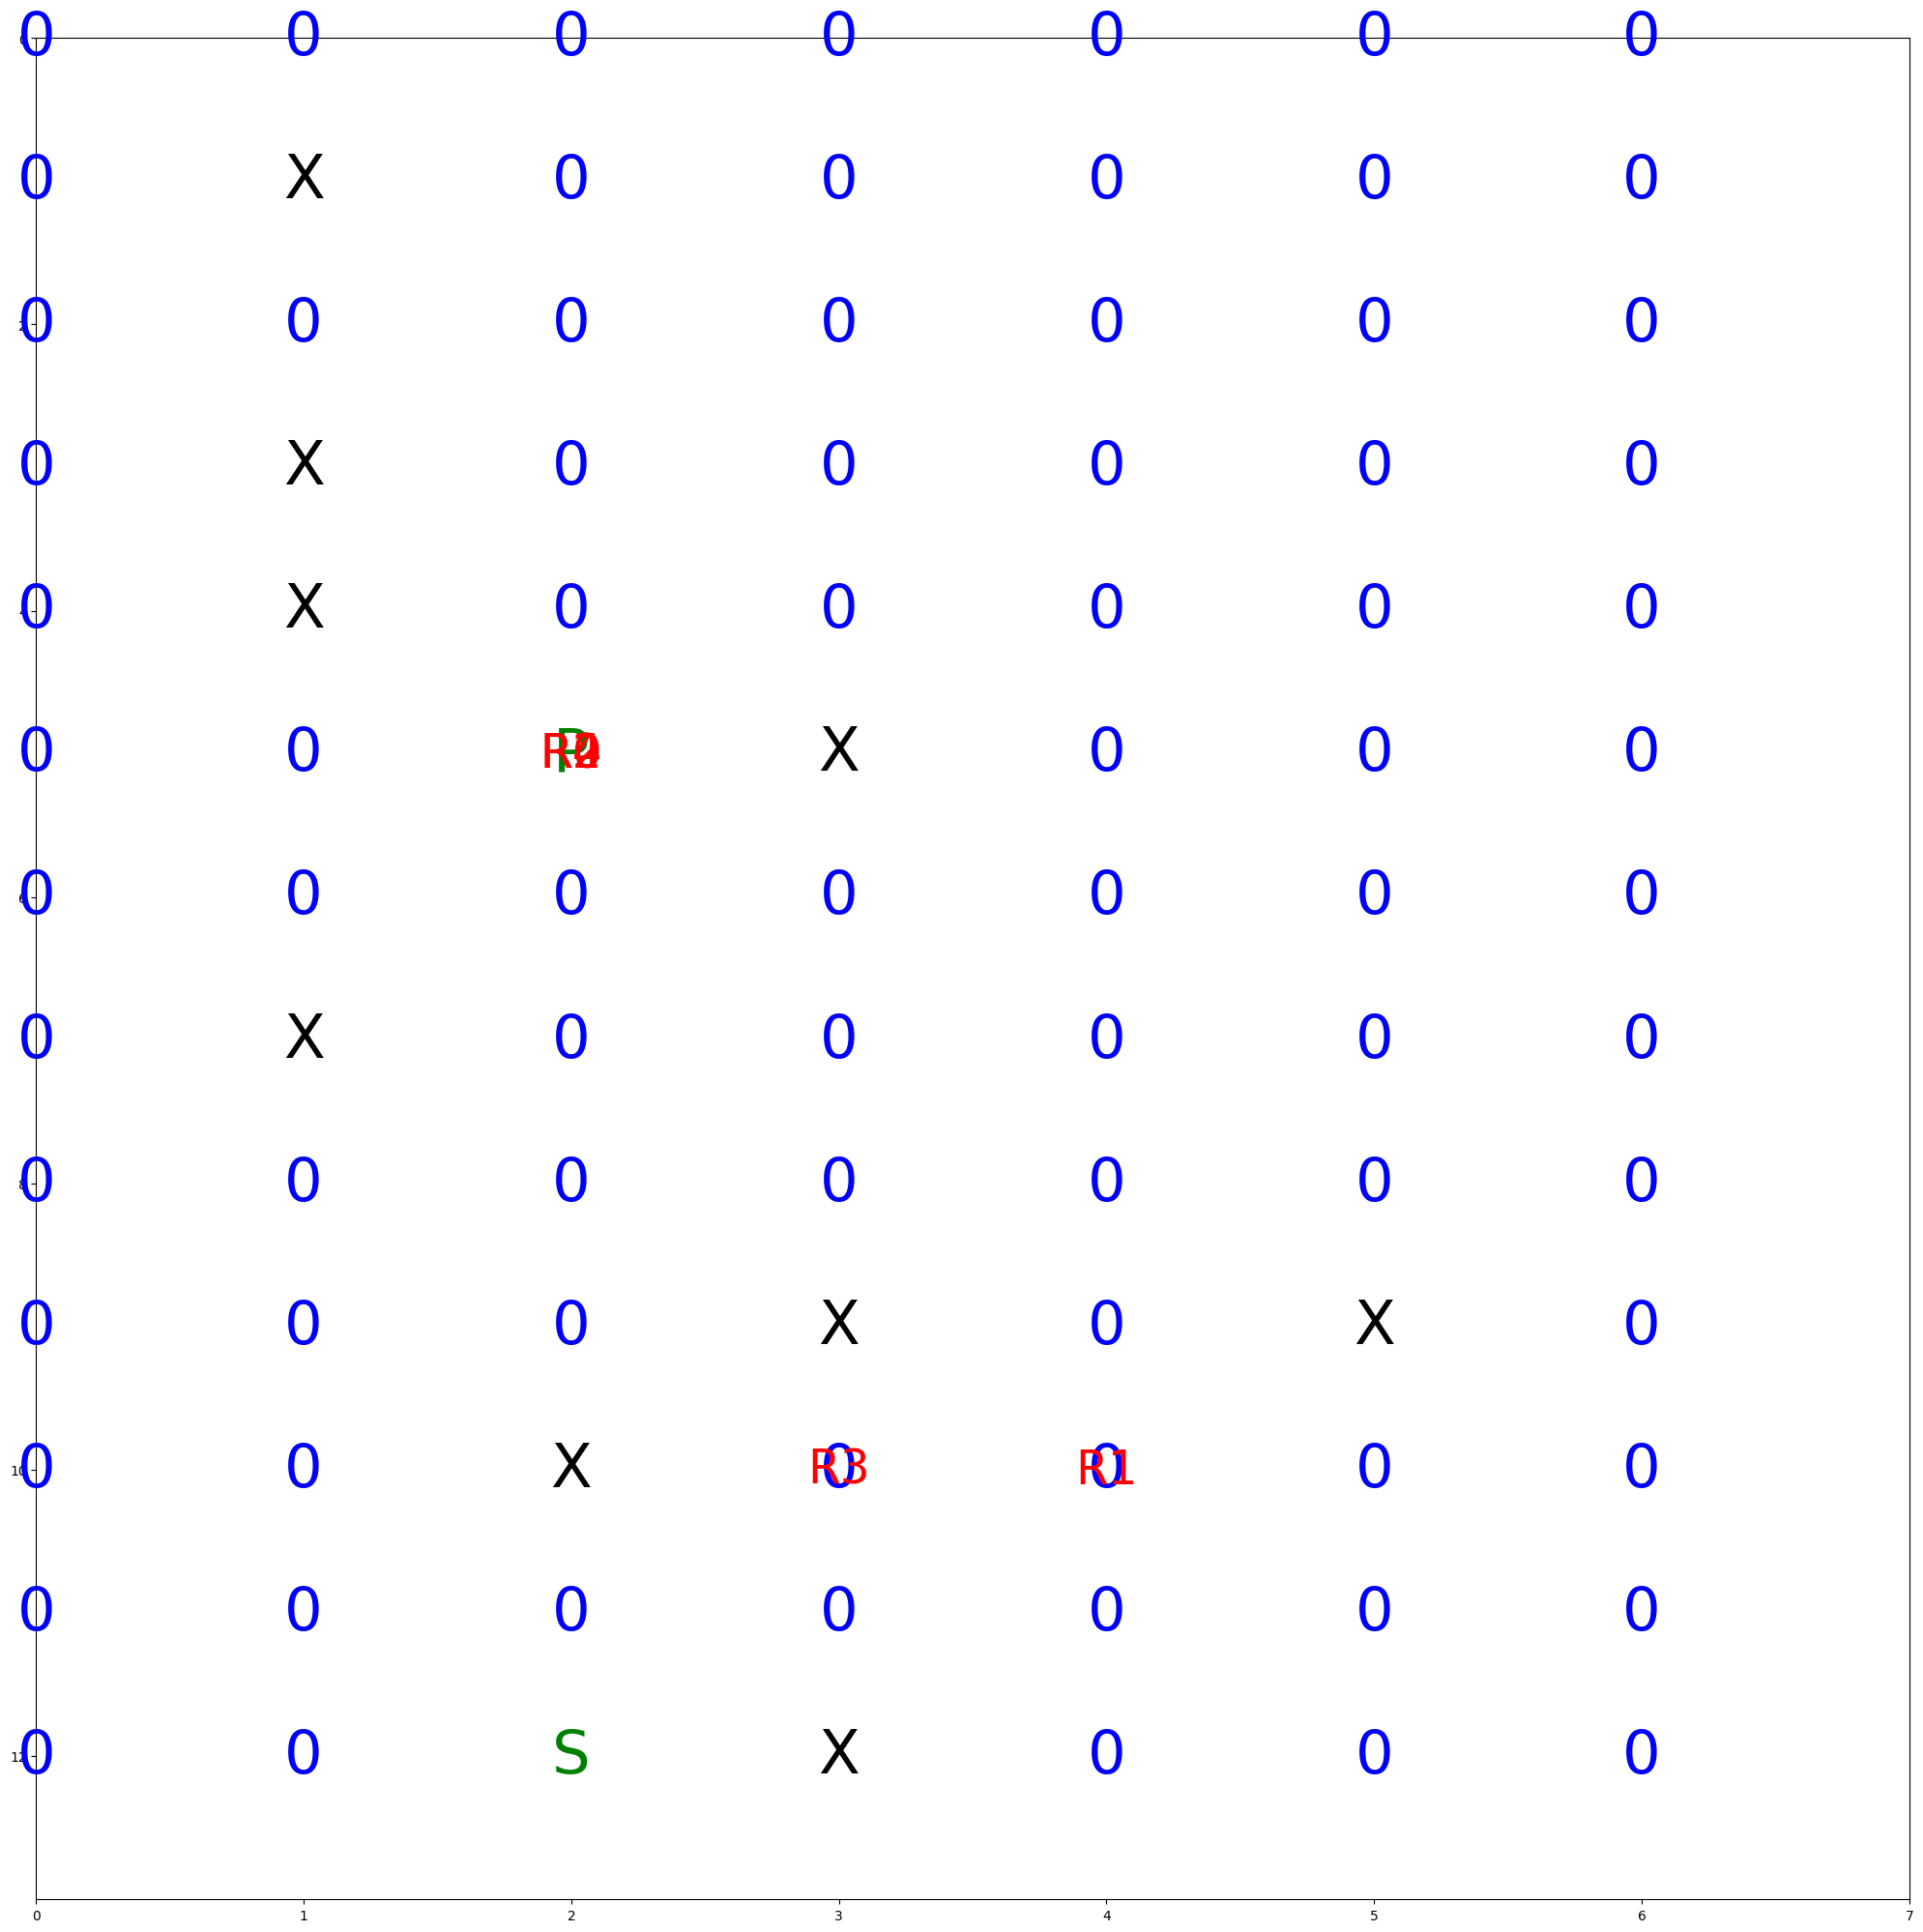

In [231]:
model = LimpiezaModel('mapa.txt') 

ani = animation.FuncAnimation(model.fig, update, fargs=(model,), frames=1000)
ani.save('animationPrueba.gif', writer='imagemagick', fps=5)
# html = HTML(ani.to_jshtml())
# display(html)


# for i in range(9):
#     model.step()
    # print("Agente 0: ", model.schedule.agents[0].posicion)
    # print("Agente 1: ", model.schedule.agents[1].posicion)
 
count = 0
for agente in model.schedule.agents:
    count += agente.pasos

print("Pasos totales: ", count)